## Imports

In [1]:
# Import the necessary modules
import requests
import json
from bs4 import BeautifulSoup
import nltk
import pandas as pd
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# NLP + Visualisation Project
This notebook will look at data from the wikipedia pages of all turing award winners.
- In a first step the notebook will fecth the winners and the introduction of their wikipedia pages
- Then the notebook will analyse and visualise this data using different NLP techniques.

## Part 1: Loading the Data

### 1.1 Defining API Functions
- get_turing_award_recipients(): Using the wikidata API we fetch the ids of the all the Turing Award recipients
- get_wikipedia_content(id): Using the ID of the recipient we can return the HTML soup of their wikipedia page
- fetch_WikiData_entity(id): Using the ID of the recipient we can fetch all of their data from the wikidata API
- fetch_intro(id): Using the recipient ID and making use of the get_wikipedia_content function, we return the intro of the wikipedia page


In [2]:
def get_turing_award_recipients(limit=500):
    """
    Query the Wikidata API for a list of Turing Award recipients.
    
    Args:
        limit: The maximum number of recipients to return.
        
    Returns:
        A list of Wikidata entity IDs for the recipients of the Turing Award.
    """
    
    # Wikidata API endpoint
    WD_API_ENDPOINT = 'https://www.wikidata.org/w/api.php'
    
    # Query Wikidata for Turing Award recipients
    params = {
        'action': 'query',
        'format': 'json',
        'list': 'search',
        'srsearch': 'haswbstatement:P166=Q185667',  # Q185667 is the Wikidata entity ID for the Turing Award
        'srlimit': limit,
    }
    response = requests.get(WD_API_ENDPOINT, params=params)
    response.raise_for_status()  # Raise an exception if the request failed
    data = response.json()
    
    # Extract the entity IDs of the Turing Award recipients
    recipients_id = [item["title"] for item in data["query"]['search']]
    
    return recipients_id


In [3]:
# Storing ids to a variable
turing_award_ids = get_turing_award_recipients()

In [4]:
def get_wikipedia_content(id):
    # Use the WikiData API to get the Wikipedia page for the given ID
    api_url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=sitelinks/urls&ids={id}"
    data = requests.get(api_url).json()
    title = data["entities"][id]["sitelinks"]["enwiki"]["title"]
    title = title.replace(" ", "_")
    
    wikipedia_url = 'https://en.wikipedia.org/wiki/{}'.format(title)
    response = requests.get(wikipedia_url)

    # Get the HTML content of the page
    html = response.content

    soup = BeautifulSoup(html, 'html.parser')
    
    return soup

In [5]:
def fetch_WikiData_entity(id):
    QUERY_URL = "https://www.wikidata.org/w/api.php?action=wbgetentities&ids={}&format=json".format(id)
    
    # Send the HTTP request to the Wikidata API
    response = requests.get(QUERY_URL)
    
    # Parse the JSON response
    data = response.json()
    
    return data

In [6]:
def fetch_intro(id):
    soup = get_wikipedia_content(id)
    startID = soup.find("table")
    endID= [soup.find("div", id="toc"), soup.find("h2")]
    intro_list= []

    """
    Citation for Fetching intro Texts
    Cite: Stackoverflow
    Date: 2022
    Code version: 1.0
    Availability: https://stackoverflow.com/questions/74580668/getting-data-between-two-div-or-a-tags-in-beautifulsoup
    """

    for sibling in startID.next_siblings:
        if sibling in endID:
            break

        para = sibling.get_text()
        if para:
            intro_list.append(para)
    intro_list = [value for value in intro_list if value != "\n"]
    intro_text = "".join(intro_list)
    
    return intro_text

### 1.2.1 Storing Data to a Dictionary
Making use of all of the defined functions we can store basic data about each winner.
- name
- their intro text on wikipedia
- birth date
- birth place
- their employers
- education
This is a slow function and improvements in processing time may come from additional parrallelism

In [7]:
award_winners = {
    "name": [],
    "intro": [],
    "birth_date": [],
    "birth_place": [],
    "employer": [],
    "educated_at": []
}

for id in turing_award_ids:
    QUERY_URL = "https://www.wikidata.org/w/api.php?action=wbgetentities&ids={}&format=json".format(id)
    
    # Send the HTTP request to the Wikidata API
    response = requests.get(QUERY_URL)
    
    # Parse the JSON response
    data = fetch_WikiData_entity(id)
    
    # Check if entity carries the human ("Q5") property
    if data["entities"][id]["claims"]["P31"][0]["mainsnak"]["datavalue"]["value"]["id"] == "Q5":
        
        # Get name from entity label title
        if "value" in data["entities"][id]["labels"]["en"]:
            name = data["entities"][id]["labels"]["en"]["value"]
        else:
            name = None

        # get intro from fetch intro function
        intro = fetch_intro(id)
    
        # In this section of code I am doing the same step for every piece of data
        # If the property for the piece of information exists
        # Fetch the value of the data or re-query the wikidata API to find the ID of that entity
        if "P569" in data["entities"][id]["claims"]:
            bday = data["entities"][id]["claims"]["P569"][0]["mainsnak"]["datavalue"]["value"]["time"]
        else:
            bday = None

        if "P19" in data["entities"][id]["claims"]:
            bplace_id = data["entities"][id]["claims"]["P19"][0]["mainsnak"]["datavalue"]["value"]["id"]
            bplace_data = fetch_WikiData_entity(bplace_id)
            bplace = bplace_data["entities"][bplace_id]["labels"]["en"]["value"]
        else:
            bplace = None

        if "P108" in data["entities"][id]["claims"]:
            employer = []
            employer_ids = [employer["mainsnak"]["datavalue"]["value"]["id"] for employer in data["entities"][id]["claims"]["P108"]]
            for employer_id in employer_ids:
                employer_data = fetch_WikiData_entity(employer_id)
                employer.append(employer_data["entities"][employer_id]["labels"]["en"]["value"])
        else:
            employer = None

        if "P69" in data["entities"][id]["claims"]:
            education = []
            education_ids = [education["mainsnak"]["datavalue"]["value"]["id"] for education in data["entities"][id]["claims"]["P69"]]
            for education_id in education_ids:
                education_data = fetch_WikiData_entity(education_id)
                education.append(education_data["entities"][education_id]["labels"]["en"]["value"])
        else:
            education = None
        
        # Append the information to our dictionary
        award_winners["name"].append(name)
        award_winners["intro"].append(intro)
        award_winners["birth_date"].append(bday)
        award_winners["birth_place"].append(bplace)
        award_winners["employer"].append(employer)
        award_winners["educated_at"].append(education)
        
        print("{} was added to award_winners".format(name))

Tim Berners-Lee was added to award_winners
Yoshua Bengio was added to award_winners
Donald Knuth was added to award_winners
Geoffrey Hinton was added to award_winners
Richard M. Karp was added to award_winners
Robert Tarjan was added to award_winners
Vint Cerf was added to award_winners
Judea Pearl was added to award_winners
Herbert Simon was added to award_winners
Marvin Minsky was added to award_winners
Ron Rivest was added to award_winners
Jeffrey David Ullman was added to award_winners
John McCarthy was added to award_winners
Dana Scott was added to award_winners
Tony Hoare was added to award_winners
Yann LeCun was added to award_winners
Manuel Blum was added to award_winners
Stephen Cook was added to award_winners
Michael Stonebraker was added to award_winners
Barbara Liskov was added to award_winners
Edsger W. Dijkstra was added to award_winners
Niklaus Wirth was added to award_winners
Michael O. Rabin was added to award_winners
Shafrira Goldwasser was added to award_winners
Fred

#### 1.2.2 Sorting names alphabetically

In [8]:
# Create a list of recipient names from the "name" column of the "award_winners" dictionary
list_of_recipient_names = award_winners["name"]

# Sort the list of recipient names alphabetically
alphabetical_list_of_recipient_names = sorted(list_of_recipient_names)

for name in alphabetical_list_of_recipient_names:
    print(name)

Adi Shamir
Alan Kay
Alan Perlis
Alfred Aho
Allen Newell
Amir Pnueli
Andrew Yao
Barbara Liskov
Bob Kahn
Butler Lampson
Charles Bachman
Charles P. Thacker
Dana Scott
David A. Patterson
Dennis M. Ritchie
Donald Knuth
Douglas Engelbart
E. Allen Emerson
Edgar F. Codd
Edmund M. Clarke
Edsger W. Dijkstra
Edward Feigenbaum
Edwin Catmull
Fernando J. Corbató
Frances E. Allen
Fred Brooks
Geoffrey Hinton
Herbert Simon
Iosif Sifakis
Ivan Sutherland
Jack Dongarra
James H. Wilkinson
Jeffrey David Ullman
Jim Gray
John Backus
John Cocke
John Edward Hopcroft
John L. Hennessy
John McCarthy
Judea Pearl
Juris Hartmanis
Ken Thompson
Kenneth E. Iverson
Kristen Nygaard
Leonard Adleman
Leslie Lamport
Leslie Valiant
Manuel Blum
Martin Edward Hellman
Marvin Minsky
Maurice Wilkes
Michael O. Rabin
Michael Stonebraker
Niklaus Wirth
Ole-Johan Dahl
Pat Hanrahan
Peter Naur
Raj Reddy
Richard E. Stearns
Richard Hamming
Richard M. Karp
Robert Tarjan
Robert W. Floyd
Robin Milner
Ron Rivest
Shafrira Goldwasser
Silvio Mical

### 1.3 Creating a Dataframe and Tokenizing the Texts
- From dictionary create a dataframe containing the same information
- Separate the intro texts into tokens for Natural Language Processing

In [9]:
# Create a new DataFrame named award_winners_intro with 5 columns
award_winners_intro = pd.DataFrame(columns=["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])

# Initialize lists for storing data
winner_name = []
count_words = []
count_sentences = []
count_para = []
common_words = []

# Loop through the elements in the "intro" column of award_winners DataFrame
for i in range(len(award_winners["name"])):
    # Lowercase and tokenize the text
    analyse_text = award_winners["intro"][i].lower()
    tokens = nltk.word_tokenize(analyse_text)
    text_words = nltk.Text(tokens)
    
    # Create a frequency distribution of words
    fdist = nltk.FreqDist(text_words)
    
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(analyse_text)

    # Get the 10 most common words
    ten_most_common_tuples = fdist.most_common(10)
    ten_most_common = []
    
    # Extract the words from the tuples
    for word in ten_most_common_tuples:
        ten_most_common.append(word[0])
        
    # Append the data to respective lists
    winner_name.append(award_winners["name"][i])
    count_words.append(len(text_words))
    count_sentences.append(len(sentences))
    
    # Count the number of paragraphs by counting newline characters
    count_graph = 0
    for letter in analyse_text:
        if letter == "\n":
            count_graph += 1
        
    count_para.append(count_graph)
    common_words.append(ten_most_common)


# Create a dictionary of lists
award_winners_dict = {"winner_name":winner_name,
                      "count_words":count_words,
                      "count_sentences":count_sentences,
                      "count_paragraphs":count_para,
                      "common_words":common_words}

# Convert the dictionary into a DataFrame named award_winners_intro
award_winners_intro = pd.DataFrame(award_winners_dict)
award_winners_intro


,winner_name,count_words,count_sentences,count_paragraphs,common_words
0,Tim Berners-Lee,8769,413,814,"[., ,, the, (, ), :, of, and, ;, ``]"
1,Yoshua Bengio,3542,137,421,"[,, ., (, ), the, :, and, [, ], bengio]"
2,Donald Knuth,11299,568,1591,"[., ,, (, ), the, of, knuth, :, [, ]]"
3,Geoffrey Hinton,5134,271,482,"[., ,, the, (, ), of, and, [, ], :]"
4,Richard M. Karp,3919,52,1029,"[(, ), the, ,, ., of, ;, and, john, in]"
...,...,...,...,...,...
70,Fernando J. Corbató,2142,70,184,"[,, (, ), ., the, ;, corbató, of, a, in]"
71,Charles Bachman,2577,157,228,"[., ,, (, ), in, the, of, :, ``, '']"
72,Butler Lampson,2207,61,227,"[(, ), ,, ., the, ;, in, /, of, and]"
73,Ole-Johan Dahl,2272,94,392,"[(, ), ., ,, the, of, ;, :, dahl, and]"


### 1.4 Preprocessing
- This code performs preprocessing on the "intro" column of the award_winners dataframe
- The preprocessing includes removing stop words, punctuation and adding a new column common_words_after_preprocessing with the 10 most common words in the preprocessed text

In [10]:
common_words_after_preprocessing = []
for i in range(len(award_winners["name"])):
    analyse_text = award_winners["intro"][i].lower()
    tokens = nltk.word_tokenize(analyse_text)
    text_words = nltk.Text(tokens)
    stopwords = nltk.corpus.stopwords.words("english")    
    
    text_no_stop = " ".join([w for w in text_words if w not in stopwords])
    content = "".join([w for w in text_no_stop if w not in string.punctuation])
    content = content.replace("  ", " ")

    token_content = nltk.word_tokenize(content)
    text_content = nltk.Text(token_content)
    
    fdist_content = nltk.FreqDist(text_content)
    
    
    ten_most_content_tuples = fdist_content.most_common(10)
    ten_most_content = []
    
    
    for word in ten_most_content_tuples:
        ten_most_content.append(word[0])
     
    common_words_after_preprocessing.append(ten_most_content)

award_winners_intro["common_words_after_preprocessing"] = common_words_after_preprocessing
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,Tim Berners-Lee,8769,413,814,"[., ,, the, (, ), :, of, and, ;, ``]","[web, bernerslee, retrieved, mwparseroutput, t..."
1,Yoshua Bengio,3542,137,421,"[,, ., (, ), the, :, and, [, ], bengio]","[bengio, retrieved, archived, original, mwpars..."
2,Donald Knuth,11299,568,1591,"[., ,, (, ), the, of, knuth, :, [, ]]","[knuth, donald, computer, retrieved, original,..."
3,Geoffrey Hinton,5134,271,482,"[., ,, the, (, ), of, and, [, ], :]","[hinton, geoffrey, neural, retrieved, learning..."
4,Richard M. Karp,3919,52,1029,"[(, ), the, ,, ., of, ;, and, john, in]","[john, richard, j, e, karp, m, w, robert, geor..."
5,Robert Tarjan,2522,106,210,"[(, ), ,, ., ;, tarjan, of, the, and, []","[tarjan, robert, mwparseroutput, e, s, retriev..."
6,Vint Cerf,9190,385,889,"[,, ., the, of, (, ), cerf, and, [, ]]","[cerf, internet, retrieved, mwparseroutput, vi..."
7,Judea Pearl,3709,140,227,"[,, (, ), ., the, of, pearl, :, ;, and]","[pearl, judea, mwparseroutput, award, 2011, sc..."
8,Herbert Simon,11521,428,1550,"[,, ., the, (, ), of, and, simon, in, :]","[simon, a, herbert, b, s, john, e, robert, eco..."
9,Marvin Minsky,5182,280,404,"[., ,, the, (, ), of, minsky, :, ;, []","[minsky, marvin, mwparseroutput, s, artificial..."


## Part 2: NLP Operations
We can now begin to do more interesting NLP
This includes:
- Stemming
- Lemmatization
- Finding synonyms and antonyms
- Common bigrams, trigrams
- Other visualisations

### 2.1 Stemming
The goal of stemming is to remove the suffixes (“ing”, “ly”, “es”, “s” etc.) from a word in order to return the base or root word. We will use a few different stemming techniques to note the differences.
- Initially: 5260 unique words
- Porter Stemmed: 1600 unqiue words
- Snowball Stemmed: 1598 unique words

In [11]:
# (a) Remove stopwords and punctuation from all intros and save the remaining texts in a list named intro_words
intro_words = []

for i in range(len(award_winners["name"])):
    analyse_text = award_winners["intro"][i].lower()
    stopwords = nltk.corpus.stopwords.words("english")    
    tokens = nltk.word_tokenize(analyse_text)
    text_words = nltk.Text(tokens)
    
    text_no_stop = " ".join([w for w in text_words if w not in stopwords])
    content = "".join([w for w in text_no_stop if w not in string.punctuation])
    content = content.replace("  ", " ")
    content = content.replace("  ", " ")

    token_content = nltk.word_tokenize(content)
    text_content = nltk.Text(token_content)
    
    intro_words.append(text_content)

In [12]:
total_words = []
for text in intro_words:
    for word in text:
        total_words.append(word)
len(total_words)

5260

In [13]:
# (b) Calculate and print the number of unique words in intro words.
unique_words = []
for text in intro_words:
    for word in text:
        if word not in unique_words:
            unique_words.append(word)
print("There are {} unique words in the intro_words list".format(len(unique_words)))

There are 1815 unique words in the intro_words list


In [14]:
# (c) Apply the PorterStemmer to stem the words in intro_words
ps = PorterStemmer()
unique_words_PorterStem = []

for text in intro_words:
    for word in text:
        PorterStem_word = ps.stem(word)
        if PorterStem_word not in unique_words_PorterStem:
            unique_words_PorterStem.append(PorterStem_word)

# Print unique left after applying the stemmer.
print("There are {} unique porter stemmed words in the intro_words list".format(len(unique_words_PorterStem)))

There are 1600 unique porter stemmed words in the intro_words list


In [15]:
# Apply the SnowballStemmer to stem the words in intro_words
ss = SnowballStemmer(language='english')
unique_words_SnowStem = []

for text in intro_words:
    for word in text:
        SnowStem_word = ss.stem(word)
        if SnowStem_word not in unique_words_SnowStem:
            unique_words_SnowStem.append(SnowStem_word)
            
print("There are {} unique Snowball stemmed words in the intro_words list".format(len(unique_words_SnowStem)))

There are 1598 unique Snowball stemmed words in the intro_words list


### 2.2 Lemmatization
The goal of lemmatization, unlike stemming, is to obtain the canonical form of the word, which is the base form of the word, usually a noun or a verb, to which the inflections are added.

In [16]:
# calculate the number of unique words before and after lemmatization
unique_words = []
unique_words_lemm = []

wnl = WordNetLemmatizer()

for text in intro_words:
    for word in text:
        if word not in unique_words:
            unique_words.append(word)
print("There are {} unique words in the intro_words list before lemmatization".format(len(unique_words)))

for text in intro_words:
    for word in text:
        lemmat_word = wnl.lemmatize(word)
        if lemmat_word not in unique_words_lemm:
            unique_words_lemm.append(lemmat_word)
print("There are {} unique words in the intro_words list after lemmatization".format(len(unique_words_lemm)))

There are 1815 unique words in the intro_words list before lemmatization
There are 1742 unique words in the intro_words list after lemmatization


### 2.3 Finding Synonyms and Antonyms
We can use NLP techniques to find synonyms and antonyms and then append those to the dataframe

In [11]:
# (a) add two new columns to the award_winners_intro dataframe: synonyms, antonyms
award_winners_intro["synonyms"] = np.nan
award_winners_intro["antonyms"] = np.nan

In [12]:
# find synoyms and return list
def get_synonyms(words):
    synonyms = []
    for w in words:
        for syn in wordnet.synsets(w):
            for l in syn.lemmas():
                synonyms.append(l.name())

    return synonyms

In [13]:
# find antonyms and return list
def get_antonyms(words):
    antonyms = []
    for w in words:
        for syn in wordnet.synsets(w):
            for l in syn.lemmas():
                if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())

    return antonyms

In [14]:
dict_syn_ant = {
    "synonyms":[],
    "antonyms":[]
}

for i in range(len(award_winners_intro)):
    dict_syn_ant["synonyms"].append(get_synonyms(award_winners_intro.loc[i,("common_words_after_preprocessing")]))
    dict_syn_ant["antonyms"].append(get_antonyms(award_winners_intro.loc[i,("common_words_after_preprocessing")]))
    
df_syn_ant = pd.DataFrame(dict_syn_ant)

award_winners_intro.drop(["synonyms", "antonyms"], axis=1, inplace=True)
award_winners_intro = pd.concat([award_winners_intro, df_syn_ant], axis=1)

In [21]:
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,495,18,4,"[the, [, ], of, ., he, and, web, ,, a]","[web, world, wide, bernerslee, computer, s, sc...","[web, web, entanglement, vane, web, network, w...","[narrow, narrow, middle, last, second]"
1,Yoshua Bengio,146,5,2,"[[, ], ,, and, the, learning, ., of, bengio, for]","[learning, bengio, deep, 5, computer, work, hi...","[learning, acquisition, eruditeness, erudition...","[shallow, shallow, idle, malfunction]"
2,Geoffrey Hinton,262,9,3,"[[, ], the, and, ,, ., of, in, for, hinton]","[hinton, deep, learning, computer, work, neura...","[deep, trench, deep, oceanic_abyss, deep, deep...","[shallow, shallow, idle, malfunction]"
3,Donald Knuth,217,8,3,"[the, of, ,, and, ., computer, knuth, is, to, []","[computer, knuth, programming, science, analys...","[computer, computing_machine, computing_device...","[synthesis, undesigned]"
4,Richard M. Karp,109,3,2,"[,, the, in, and, of, computer, ., for, karp, (]","[computer, karp, theory, algorithms, science, ...","[computer, computing_machine, computing_device...",[unborn]
5,Robert Tarjan,75,4,1,"[,, and, tarjan, is, ., the, of, computer, sci...","[tarjan, computer, scientist, s, university, r...","[computer, computing_machine, computing_device...",[unborn]
6,Vint Cerf,106,2,1,"[[, ], the, ,, of, and, 2, is, internet, .]","[2, internet, national, medal, vinton, gray, c...","[two, 2, II, deuce, two, 2, ii, internet, net,...","[international, local]"
7,Judea Pearl,200,6,2,"[the, ,, and, for, of, [, ], ., pearl, (]","[pearl, causality, judea, 4, computer, probabi...","[pearl, bone, ivory, pearl, off-white, drop, b...","[natural, stupidity, devolution, nondevelopment]"
8,Herbert Simon,237,8,2,"[,, the, of, and, [, ], science, ., was, in]","[science, computer, political, simon, 9, 2001,...","[science, scientific_discipline, skill, scienc...",[nonpolitical]
9,Marvin Minsky,78,2,2,"[,, and, of, [, ], ai, minsky, (, ), the]","[ai, minsky, marvin, lee, august, 9, 1927, –, ...","[Army_Intelligence, AI, artificial_intelligenc...",[windward]


### 2.4 Bigrams and Trigrams
A Bigram is a sequence of 2 words and is used in NLP to capture the context of a word in a sentence. For example, in the sentence "I love to play football", the bigrams would be ["I love", "love to", "to play", "play football"].
- Manually calculate bigrams and return most common

In [22]:
tokenized_intros = []
for intro in award_winners["intro"]:
    analyse_text = "".join(intro).lower()
    token = nltk.word_tokenize(analyse_text)
    tokenized_intros.append(token)
award_winners["tokenized_intros"] =  tokenized_intros

In [23]:
def get_bigrams_frequency(list_of_intros):
    stopwords = nltk.corpus.stopwords.words("english")
    clean_list_of_intros = []
    list_of_bigrams = []
    dict_bigrams = {}
    
    for intro in list_of_intros:
        clean_intro = []
        for word in intro:
            if word not in stopwords:
                if word not in string.punctuation:
                    clean_intro.append(word)
        clean_list_of_intros.append(clean_intro)
    
    for intro in clean_list_of_intros:
        list_of_bigrams.append(list(nltk.bigrams(intro)))
        
    for intro in list_of_bigrams:
        for bigram in intro:
            if bigram in dict_bigrams:
                dict_bigrams[bigram] += 1
            else:
                dict_bigrams[bigram] = 1
    
    dict_bigrams = dict(sorted(dict_bigrams.items(), key=lambda item: item[1], reverse=True))
    
    return dict_bigrams

In [24]:
winner_bigrams = get_bigrams_frequency(tokenized_intros)

In [25]:
iterration = 0
for key in winner_bigrams:
    if iterration == 15:
        break
    print(key)
    iterration += 1

('turing', 'award')
('computer', 'scientist')
('computer', 'science')
('american', 'computer')
('body.skin-minerva', '.mw-parser-output')
('artificial', 'intelligence')
('programming', 'language')
('best', 'known')
('5', '6')
('7', '8')
('programming', 'languages')
('national', 'academy')
('professor', 'computer')
('3', '4')
('9', '10')


### 2.5 Visualisation

We can now look at a few different basic visualisations to bettwer understand the data

#### 2.5.1 Bar Plots
Here we look at three different parameters
   - Word Count
   - Sentence Count
   - Paragraph Count

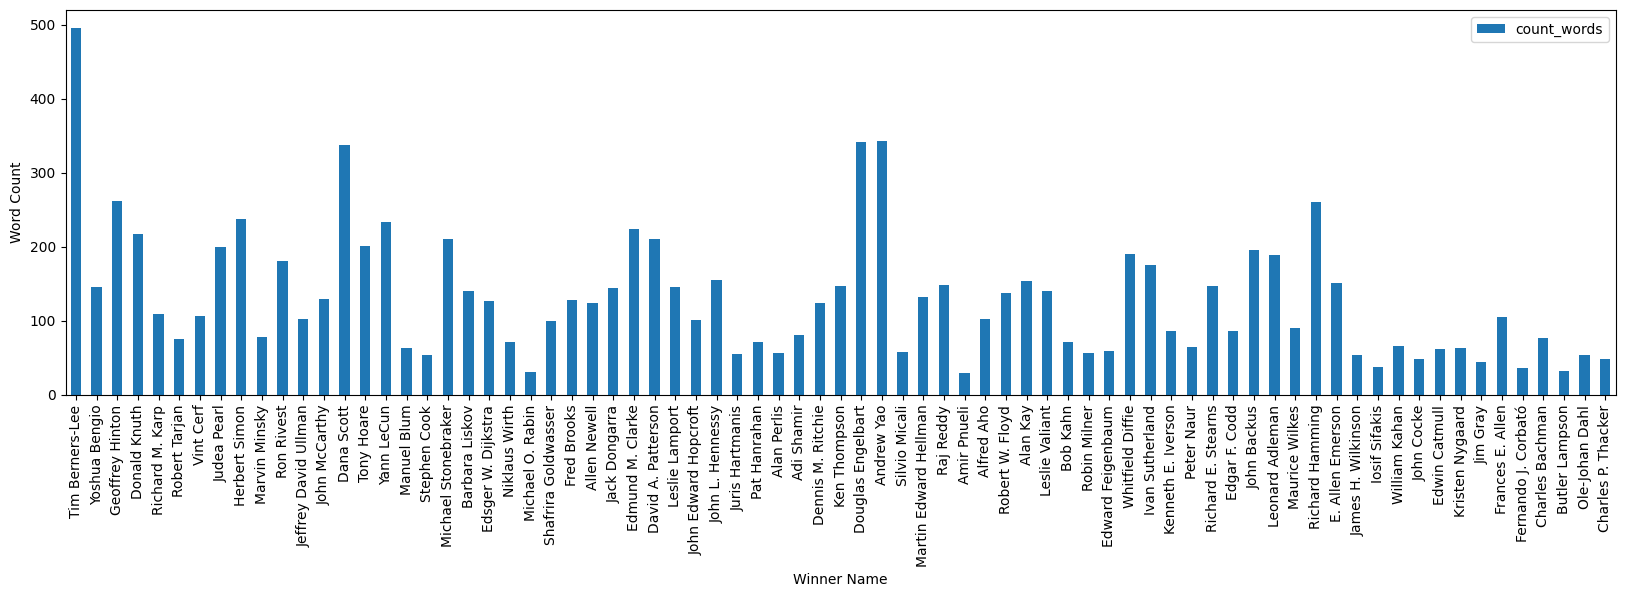

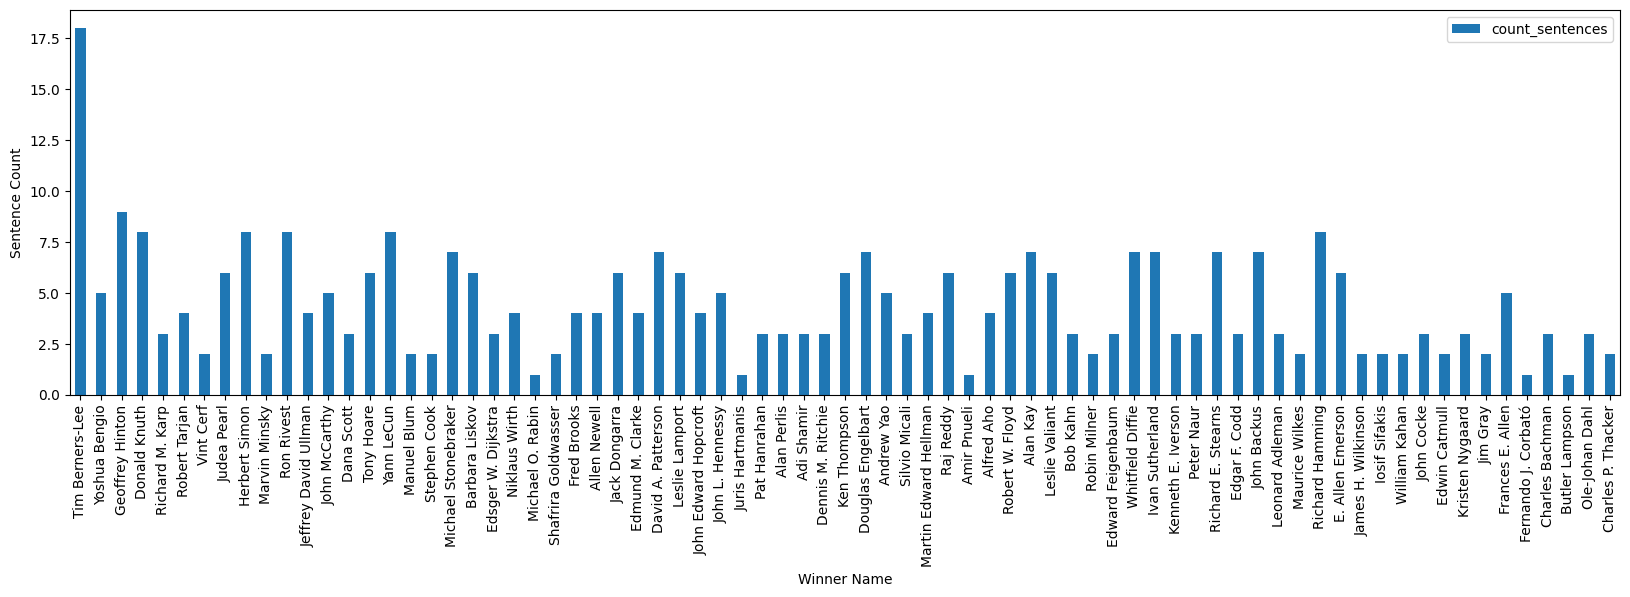

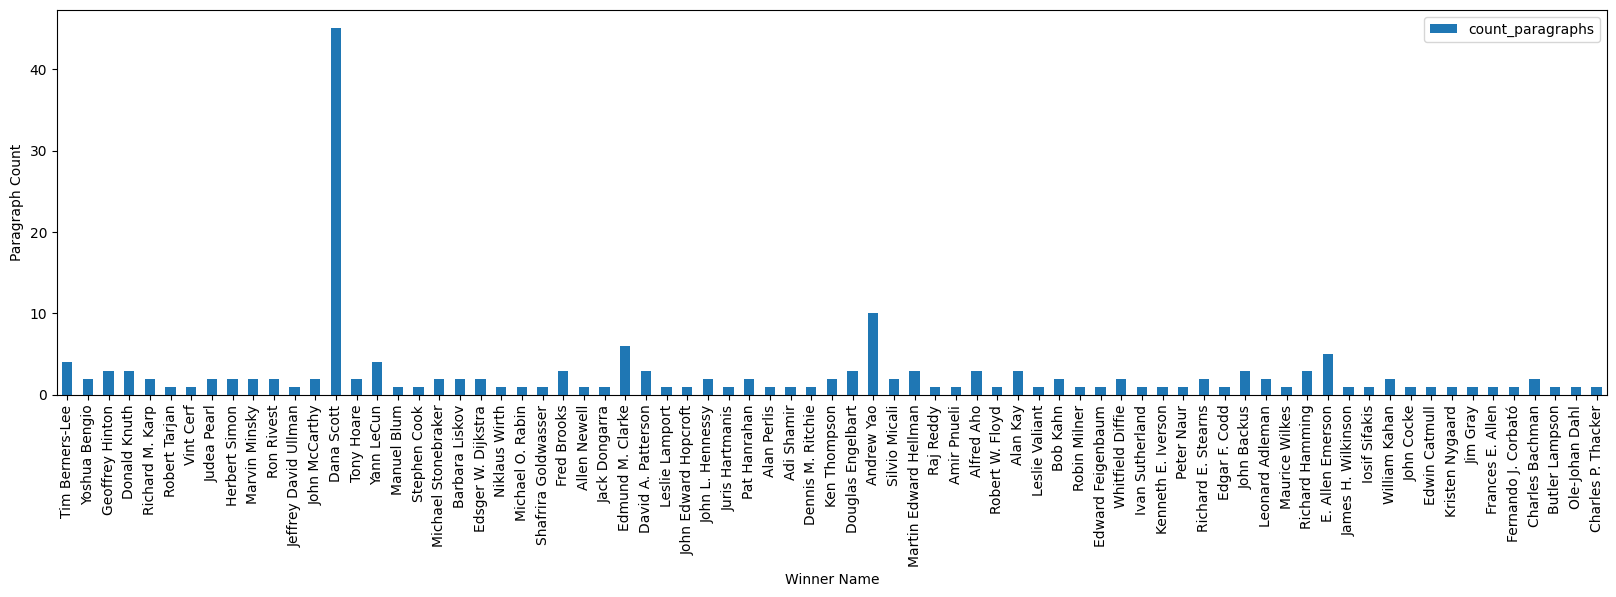

In [26]:
# Create the bar plot
plot1 = award_winners_intro.plot.bar(x = "winner_name", y = "count_words", figsize=(20, 5), xlabel="Winner Name", ylabel="Word Count")
plot2 = award_winners_intro.plot.bar(x = "winner_name", y = "count_sentences", figsize=(20, 5), xlabel="Winner Name", ylabel="Sentence Count")
plot3 = award_winners_intro.plot.bar(x = "winner_name", y = "count_paragraphs", figsize=(20, 5), xlabel="Winner Name", ylabel="Paragraph Count")

# Show the plot
plt.show()

#### 2.5.2 Sorted Bar Plot

/var/folders/n3/tlclksws2jxfmjsh74wg0ygr0000gn/T/ipykernel_10018/227384211.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(names1)
/var/folders/n3/tlclksws2jxfmjsh74wg0ygr0000gn/T/ipykernel_10018/227384211.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(names2)
/var/folders/n3/tlclksws2jxfmjsh74wg0ygr0000gn/T/ipykernel_10018/227384211.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(names3)


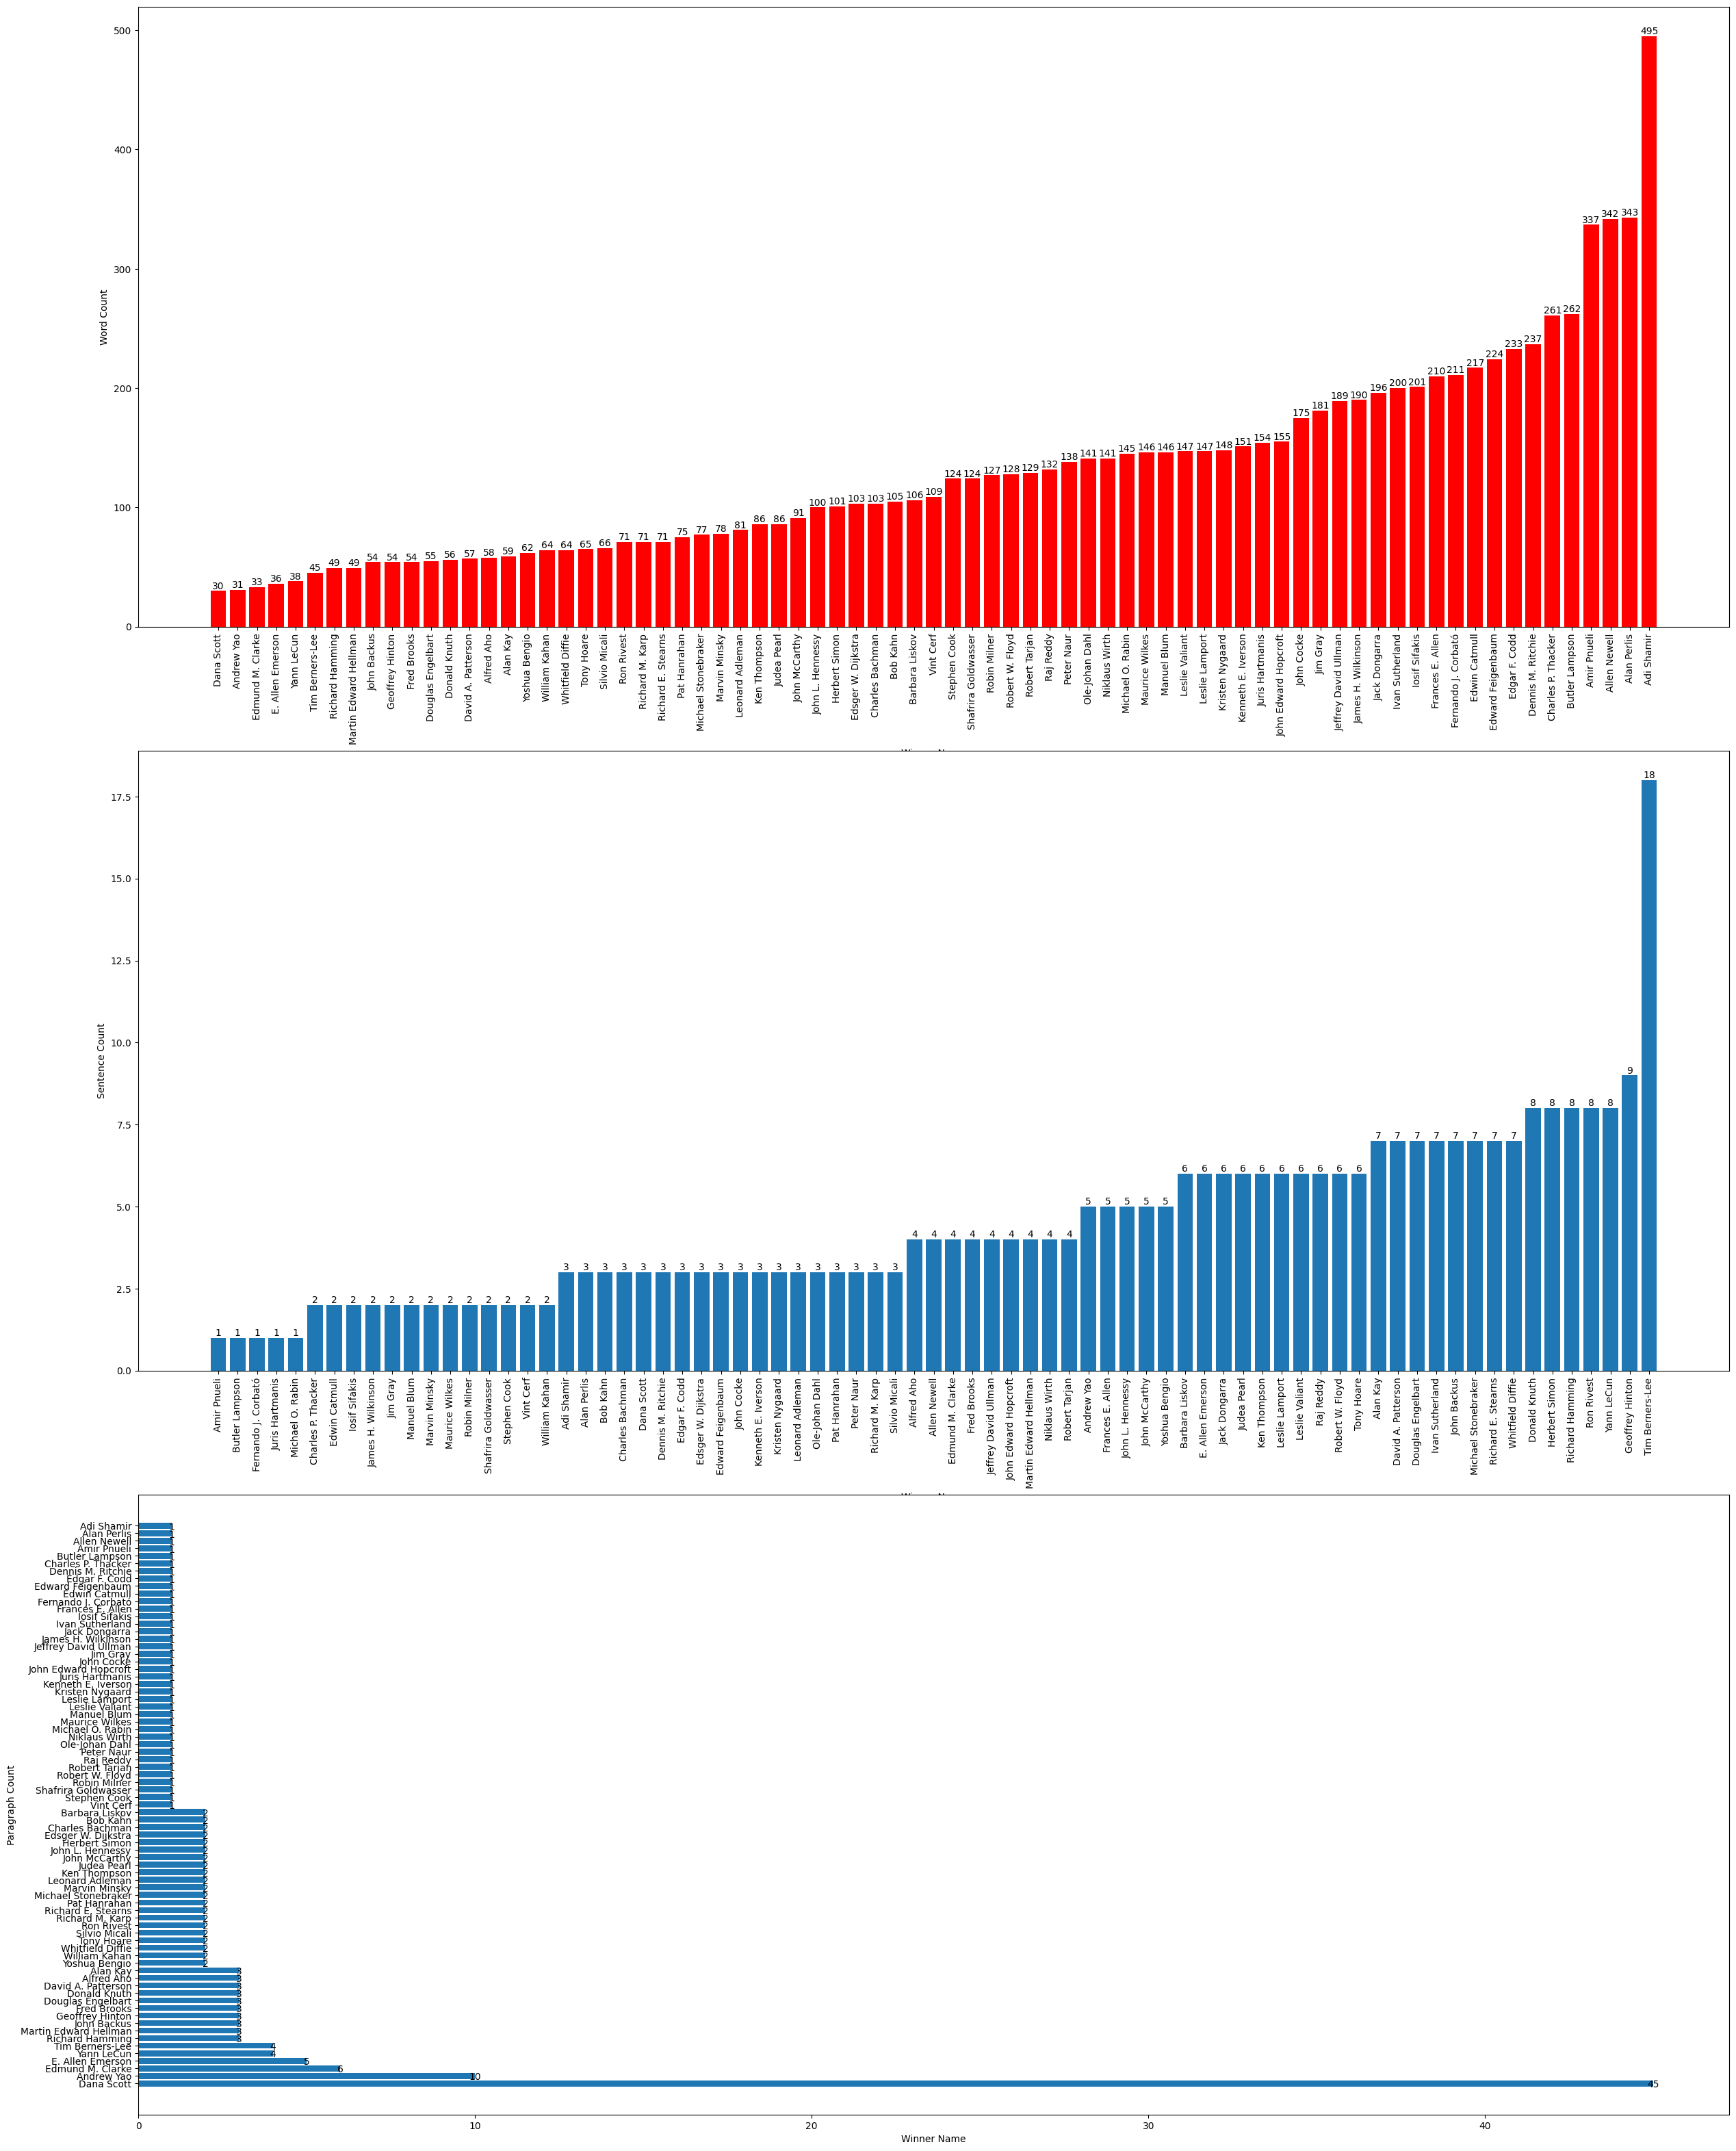

In [28]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(30, 40))

names = award_winners_intro["winner_name"]
n_words = award_winners_intro["count_words"]
n_sent = award_winners_intro["count_sentences"]
n_para = award_winners_intro["count_paragraphs"]


n_words, names1 = zip(*sorted(zip(n_words, names), reverse=False))
n_sent, names2 = zip(*sorted(zip(n_sent, names), reverse=False))
n_para, names3 = zip(*sorted(zip(n_para, names), reverse=True))

# Create the first bar plot
word_bar = ax1.bar(x=names1, height=n_words, color="r")
ax1.set_xlabel("Winner Name")
ax1.set_ylabel("Word Count")

# Create the second bar plot
sent_bar = ax2.bar(x=names2, height=n_sent)
ax2.set_xlabel("Winner Name")
ax2.set_ylabel("Sentence Count")

# Create the third bar plot
para_bar = ax3.barh(y=names3, width=n_para)
ax3.set_xlabel("Winner Name")
ax3.set_ylabel("Paragraph Count")


# Update the tick labels to reflect the sorted order
ax1.set_xticklabels(names1)
ax1.set_xticklabels(names2)
ax1.set_xticklabels(names3)

plt.setp(ax1.get_xticklabels(), rotation=90)
plt.setp(ax2.get_xticklabels(), rotation=90)

# Add labels to the bars
for bar in word_bar:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
            '%d' % int(height), ha='center', va='bottom')
    
# Add labels to the bars
for bar in sent_bar:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
            '%d' % int(height), ha='center', va='bottom')
    
# Add labels to the bars
for bar in para_bar:
    width = bar.get_width()
    ax3.text(width, bar.get_y() - bar.get_height()/2,
            '%d' % int(width), ha='center', va='bottom')


# Show the plot
plt.show()

#### 2.5.3 Heatmap
Using the bigrams previously calculated we can find the most common bigrams and identify in which paragraphs they occur the most. This is visualised using a heatmap. Interesting bigrams include
- ["turing","award"]
- ["computer","science"]

In [29]:
fifteen_bigrams = []
iterration = 0
for key in winner_bigrams:
    if iterration == 15:
        break
    fifteen_bigrams.append(key)
    iterration += 1

In [30]:
def get_bigrams(intro_text):
    stopwords = nltk.corpus.stopwords.words("english")
    list_of_bigrams = []
    
    clean_intro = []
    for word in intro_text:
        if word not in stopwords:
            if word not in string.punctuation:
                clean_intro.append(word)

    list_of_bigrams.append(list(nltk.bigrams(clean_intro)))
    return list_of_bigrams

In [31]:
heatmap_array = []
for i in range(len(award_winners["name"])):
    count_bigrams_in_name = np.zeros(15)
    [intro_bigrams] = get_bigrams(award_winners["tokenized_intros"][i])
    for bigram in intro_bigrams:
        for i in range(len(fifteen_bigrams)):
            if bigram == fifteen_bigrams[i]:
                count_bigrams_in_name[i] += 1
    heatmap_array.append(count_bigrams_in_name)
heatmap_array = np.array(heatmap_array)

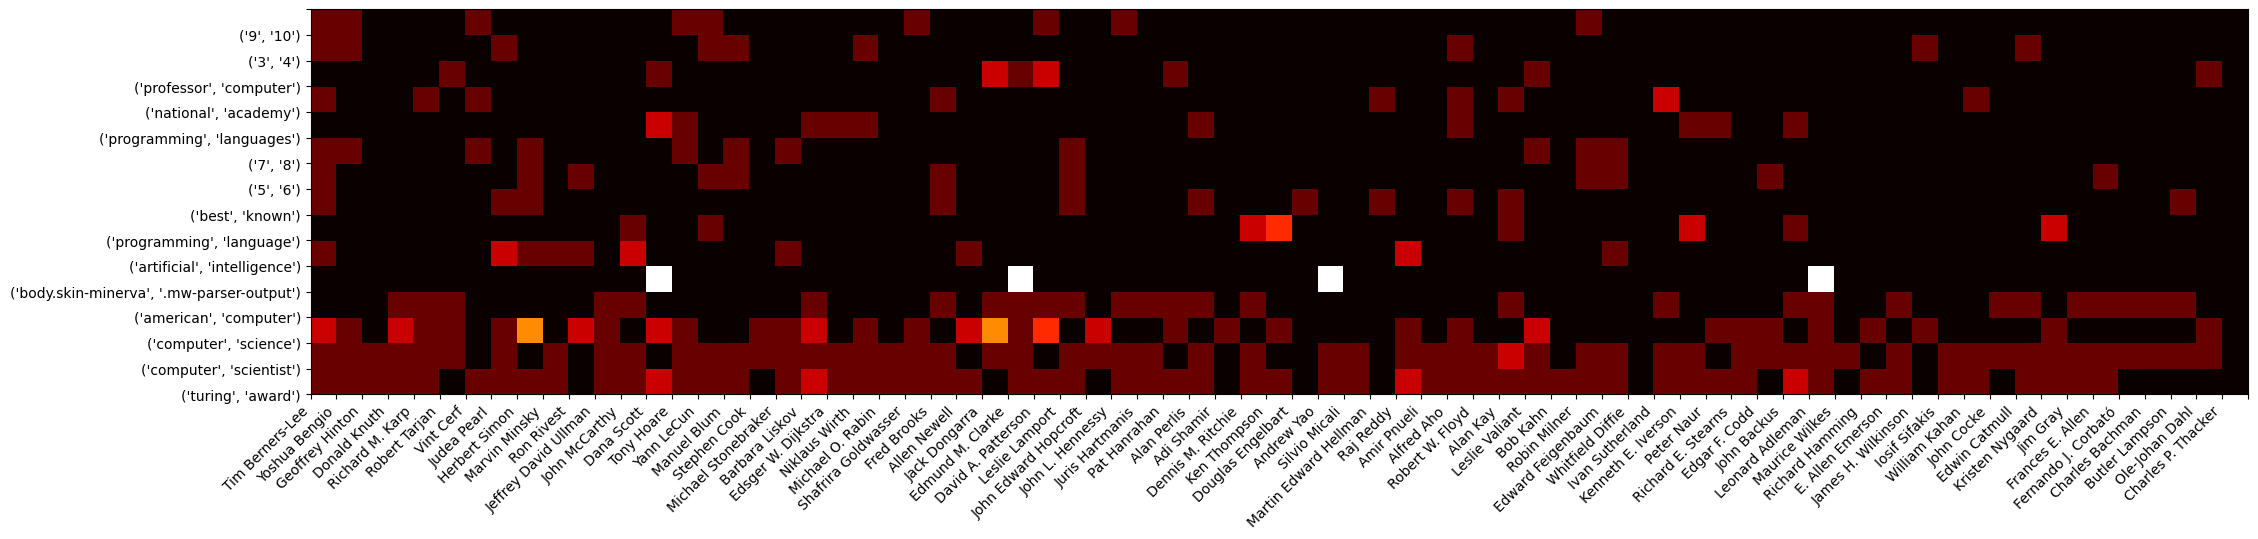

In [32]:
fig, ax = plt.subplots(figsize=(25, 5))
heatmap = ax.pcolor(heatmap_array.T, cmap='hot')

# Set the x-axis tick labels to the winner names
ax.set_xticks(np.arange(len(award_winners["name"])))
ax.set_xticklabels(award_winners["name"], rotation=45, ha='right')

# Set the y-axis tick labels to the bigrams
ax.set_yticks(np.arange(len(fifteen_bigrams)))
ax.set_yticklabels(fifteen_bigrams)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()